# ML-IMC data

## Analysis of ML-IMC training on LJ data

## The data is obtained with my Julia MC code that can be found here:

(https://github.com/mikhail-a-ivanov/mcLJ)

In [1]:
using Plots
using Statistics
using BSON: @save, @load

include("src/distances.jl")
include("src/readLJ.jl")
include("src/ML-IMC.jl");

# 0. Preparation

In [2]:
HOME = pwd()

"/largedisk/ML-IMC-data"

In [3]:
cd(HOME)

In [4]:
"""
function readloss(outname)

Reads loss data from ML-IMC output file
"""
function readloss(outname)
    lossdata = []
    file = open(outname, "r")
    lines = readlines(file)
    for line in lines
        if length(split(line)) > 0 && split(line)[1] == "Loss"
            append!(lossdata, parse(Float64, split(line)[end]))
        end
    end
    close(file)
    iters = 1:length(lossdata)
    return(iters, lossdata)
end;

In [5]:
"""
histname(rdfname)

Reads distance histogram file produced
by ML-IMC.jl
"""
function readhist(histname)
    file = open(histname, "r")
    println("\nReading histogram data from $(histname)...")
    lines = readlines(file)
    ncomments = 1
    nlines = length(lines) - ncomments
    bins = zeros(nlines)
    hist = zeros(nlines)
    for i in (1 + ncomments):length(lines)
        rdfline = split(lines[i])
        if length(rdfline) == 2
            bins[i - ncomments] = parse(Float64, rdfline[1])
            hist[i - ncomments] = parse(Float64, rdfline[2])
        end
    end
    return(bins, hist)
    close(file)
end;

Reading the reference histogram:

In [6]:
bins, rdfref, histref = readRDF("mcLJ/rdf-mean-p40.dat")
histref ./= 500;


Reading reference data from mcLJ/rdf-mean-p40.dat...


In [121]:
palette(:tab10)

# 1. Training with RDF

# 1.1. η = 0.0001; μ = 0.5

In [122]:
cd(HOME * "/RDF_0.0001_0.5") 

In [19]:
run(`cat LJML-init.in`);

# System
N             = 1000                 # Number of particles
box           = 36.405 36.405 36.405 # Box vectors [Å]

# Conditions
T             = 95.0                 # [K]

# Monte Carlo parameters          
delta         = 0.75                 # Max displacement [Å]
steps         = 20000000             # Total number of MC steps
Eqsteps       = 10000000             # Equilibration MC steps

# Output control          
xyzout        = 0                    # XYZ output frequency
outfreq       = 1000                 # Output frequency

# RDF parameters          
binWidth      = 0.025                # [Å]
Nbins         = 600                  # Number of bins

# Learning parameters
paircorr      = RDF                  # Type of pair correlations (RDF or histogram)
iters         = 50                   # Number of learning iterations
activation    = identity             # Activation function
optimizer     = Momentum             # Optimizer (other options - Descent)
rate          = 0.0

In [85]:
itersRDF1, lossdataRDF1 = readloss("ML-IMC.out");

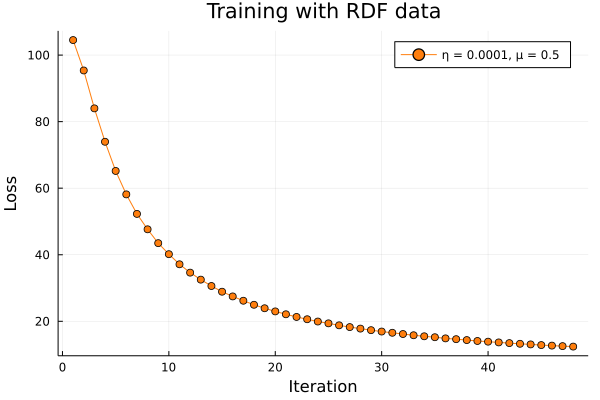

In [124]:
plot(itersRDF1, lossdataRDF1, title="Training with RDF data", 
    label="η = 0.0001, μ = 0.5", marker=(:dot), color=palette(:tab10)[2])
xlabel!("Iteration")
ylabel!("Loss")

In [125]:
binsRDF, rdfNN1 = readhist("rdfNN-iter-49.dat");


Reading histogram data from rdfNN-iter-49.dat...


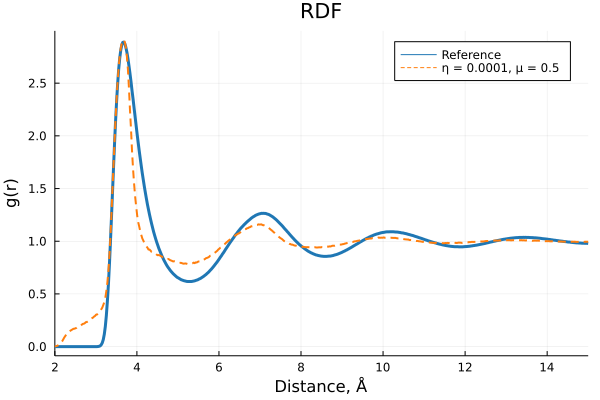

In [126]:
plot(bins, rdfref, xlim = (2, 15), linewidth=3, 
    labels="Reference", title="RDF", legend=:best, color=palette(:tab10)[1])
plot!(binsRDF, rdfNN1, xlim = (2, 15), linewidth=2, 
    linestyle=:dash, label="η = 0.0001, μ = 0.5", color=palette(:tab10)[2])
xlabel!("Distance, Å")
ylabel!("g(r)")

RDF is very close to convergence! I need to decrease the learning rate or increase friction.

In [127]:
@load "model-iter-49.bson" model
model1 = copy(model.weight');

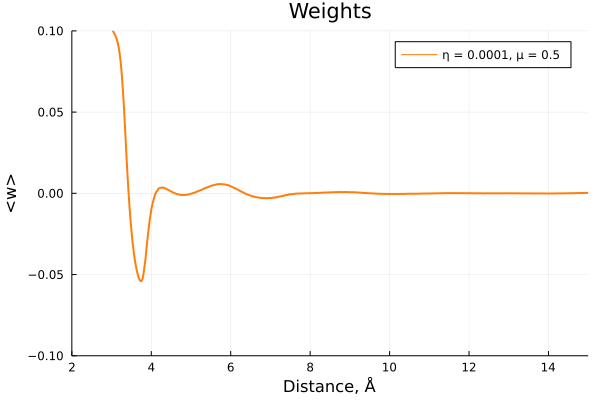

In [139]:
plot(bins, model1, title="Weights", 
    label="η = 0.0001, μ = 0.5", xlim=(2, 15), ylim=(-0.1, 0.1), lw=2, color=palette(:tab10)[2])
xlabel!("Distance, Å")
ylabel!("<w>")

# 1.2. η = 0.0001; μ = 0.75

In [129]:
cd(HOME * "/RDF_0.0001_0.75") 

In [130]:
run(`cat LJML-init.in`);

# System
N             = 1000                 # Number of particles
box           = 36.405 36.405 36.405 # Box vectors [Å]

# Conditions
T             = 95.0                 # [K]

# Monte Carlo parameters          
delta         = 0.75                 # Max displacement [Å]
steps         = 20000000             # Total number of MC steps
Eqsteps       = 10000000             # Equilibration MC steps

# Output control          
xyzout        = 0                    # XYZ output frequency
outfreq       = 1000                 # Output frequency

# RDF parameters          
binWidth      = 0.025                # [Å]
Nbins         = 600                  # Number of bins

# Learning parameters
paircorr      = RDF                  # Type of pair correlations (RDF or histogram)
iters         = 50                   # Number of learning iterations
activation    = identity             # Activation function
optimizer     = Momentum             # Optimizer (other options - Descent)
rate          = 0.0

In [131]:
itersRDF2, lossdataRDF2 = readloss("ML-IMC.out");

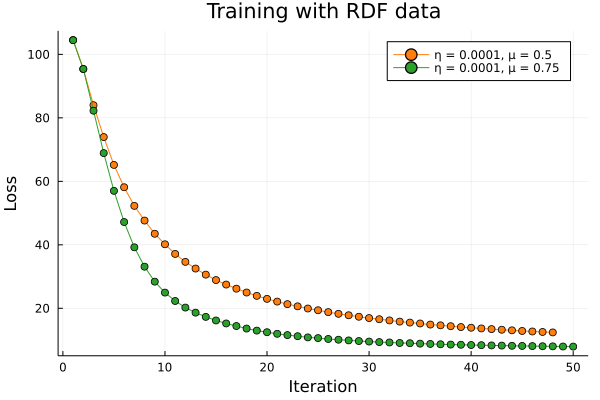

In [132]:
plot(itersRDF1, lossdataRDF1, title="Training with RDF data", 
    label="η = 0.0001, μ = 0.5", marker=(:dot), color=palette(:tab10)[2])
plot!(itersRDF2, lossdataRDF2, label="η = 0.0001, μ = 0.75", 
    marker=(:dot), color=palette(:tab10)[3])
xlabel!("Iteration")
ylabel!("Loss")

In [133]:
binsRDF, rdfNN2 = readhist("rdfNN-iter-50.dat");


Reading histogram data from rdfNN-iter-50.dat...


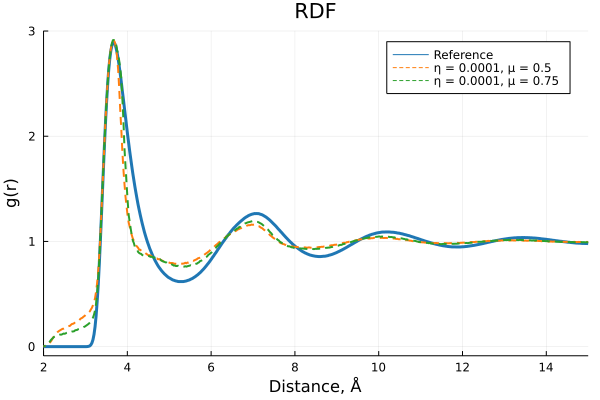

In [134]:
plot(bins, rdfref, xlim = (2, 15), linewidth=3, 
    labels="Reference", title="RDF", legend=:best, color=palette(:tab10)[1])
plot!(binsRDF, rdfNN1, xlim = (2, 15), linewidth=2, 
    linestyle=:dash, label="η = 0.0001, μ = 0.5", color=palette(:tab10)[2])
plot!(binsRDF, rdfNN2, xlim = (2, 15), linewidth=2, 
    linestyle=:dash, label="η = 0.0001, μ = 0.75", color=palette(:tab10)[3])
xlabel!("Distance, Å")
ylabel!("g(r)")

In [135]:
@load "model-iter-50.bson" model
model2 = copy(model.weight');

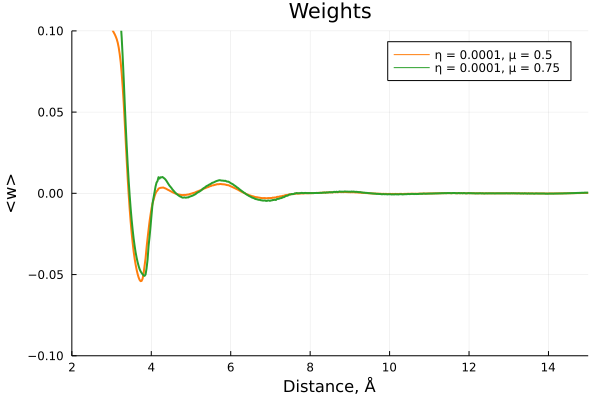

In [138]:
plot(bins, model1, title="Weights", 
    label="η = 0.0001, μ = 0.5", xlim=(2, 15), ylim=(-0.1, 0.1), lw=2, color=palette(:tab10)[2])
plot!(bins, model2, 
    label="η = 0.0001, μ = 0.75", xlim=(2, 15), ylim=(-0.1, 0.1), lw=2, color=palette(:tab10)[3])
xlabel!("Distance, Å")
ylabel!("<w>")

# 1.3. η = 0.0005; μ = 0.5

In [140]:
cd(HOME * "/RDF_0.0005_0.5") 

In [141]:
run(`cat LJML-init.in`);

# System
N             = 1000                 # Number of particles
box           = 36.405 36.405 36.405 # Box vectors [Å]

# Conditions
T             = 95.0                 # [K]

# Monte Carlo parameters          
delta         = 0.75                 # Max displacement [Å]
steps         = 20000000             # Total number of MC steps
Eqsteps       = 10000000             # Equilibration MC steps

# Output control          
xyzout        = 0                    # XYZ output frequency
outfreq       = 1000                 # Output frequency

# RDF parameters          
binWidth      = 0.025                # [Å]
Nbins         = 600                  # Number of bins

# Learning parameters
paircorr      = RDF                  # Type of pair correlations (RDF or histogram)
iters         = 50                   # Number of learning iterations
activation    = identity             # Activation function
optimizer     = Momentum             # Optimizer (other options - Descent)
rate          = 0.0

In [142]:
itersRDF3, lossdataRDF3 = readloss("ML-IMC.out");

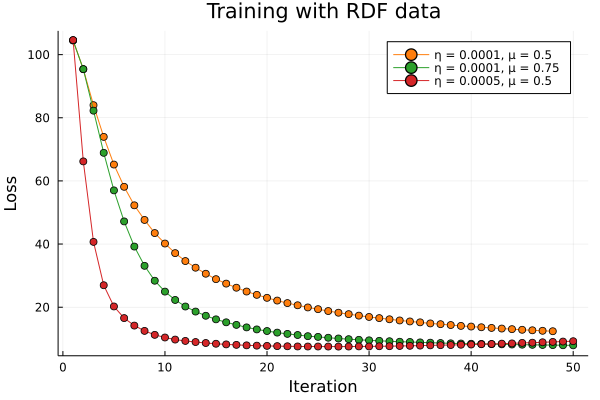

In [144]:
plot(itersRDF1, lossdataRDF1, title="Training with RDF data", 
    label="η = 0.0001, μ = 0.5", marker=(:dot), color=palette(:tab10)[2])
plot!(itersRDF2, lossdataRDF2, label="η = 0.0001, μ = 0.75", 
    marker=(:dot), color=palette(:tab10)[3])
plot!(itersRDF3, lossdataRDF3, label="η = 0.0005, μ = 0.5", 
    marker=(:dot), color=palette(:tab10)[4])
xlabel!("Iteration")
ylabel!("Loss")

In [151]:
binsRDF, rdfNN3 = readhist("rdfNN-iter-20.dat");


Reading histogram data from rdfNN-iter-20.dat...


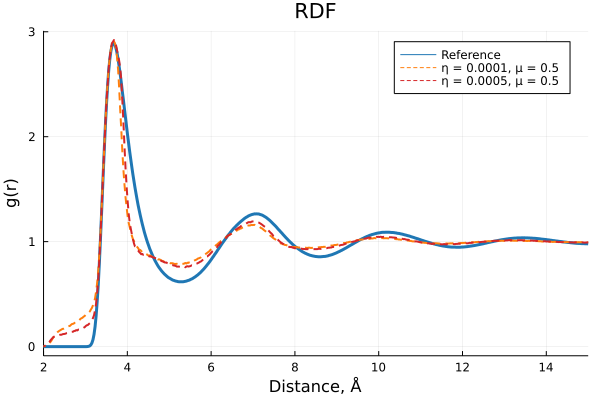

In [152]:
plot(bins, rdfref, xlim = (2, 15), linewidth=3, 
    labels="Reference", title="RDF", legend=:best, color=palette(:tab10)[1])
plot!(binsRDF, rdfNN1, xlim = (2, 15), linewidth=2, 
    linestyle=:dash, label="η = 0.0001, μ = 0.5", color=palette(:tab10)[2])
plot!(binsRDF, rdfNN3, xlim = (2, 15), linewidth=2, 
    linestyle=:dash, label="η = 0.0005, μ = 0.5", color=palette(:tab10)[4])
xlabel!("Distance, Å")
ylabel!("g(r)")

In [153]:
@load "model-iter-20.bson" model
model3 = copy(model.weight');

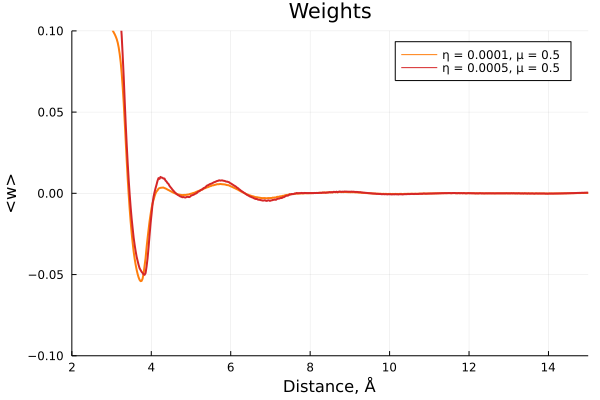

In [155]:
plot(bins, model1, title="Weights", 
    label="η = 0.0001, μ = 0.5", xlim=(2, 15), ylim=(-0.1, 0.1), lw=2, color=palette(:tab10)[2])
plot!(bins, model3, 
    label="η = 0.0005, μ = 0.5", xlim=(2, 15), ylim=(-0.1, 0.1), lw=2, color=palette(:tab10)[4])
xlabel!("Distance, Å")
ylabel!("<w>")

# 1.4. η = 0.0005; μ = 0.75

In [156]:
cd(HOME * "/RDF_0.0005_0.75") 

In [157]:
run(`cat LJML-init.in`);

# System
N             = 1000                 # Number of particles
box           = 36.405 36.405 36.405 # Box vectors [Å]

# Conditions
T             = 95.0                 # [K]

# Monte Carlo parameters          
delta         = 0.75                 # Max displacement [Å]
steps         = 20000000             # Total number of MC steps
Eqsteps       = 10000000             # Equilibration MC steps

# Output control          
xyzout        = 0                    # XYZ output frequency
outfreq       = 1000                 # Output frequency

# RDF parameters          
binWidth      = 0.025                # [Å]
Nbins         = 600                  # Number of bins

# Learning parameters
paircorr      = RDF                  # Type of pair correlations (RDF or histogram)
iters         = 50                   # Number of learning iterations
activation    = identity             # Activation function
optimizer     = Momentum             # Optimizer (other options - Descent)
rate          = 0.0

In [158]:
itersRDF4, lossdataRDF4 = readloss("ML-IMC.out");

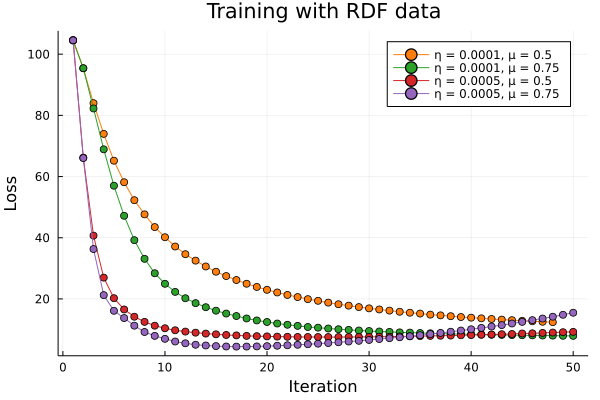

In [159]:
plot(itersRDF1, lossdataRDF1, title="Training with RDF data", 
    label="η = 0.0001, μ = 0.5", marker=(:dot), color=palette(:tab10)[2])
plot!(itersRDF2, lossdataRDF2, label="η = 0.0001, μ = 0.75", 
    marker=(:dot), color=palette(:tab10)[3])
plot!(itersRDF3, lossdataRDF3, label="η = 0.0005, μ = 0.5", 
    marker=(:dot), color=palette(:tab10)[4])
plot!(itersRDF4, lossdataRDF4, label="η = 0.0005, μ = 0.75", 
    marker=(:dot), color=palette(:tab10)[5])
xlabel!("Iteration")
ylabel!("Loss")

In [160]:
binsRDF, rdfNN4 = readhist("rdfNN-iter-15.dat");


Reading histogram data from rdfNN-iter-15.dat...


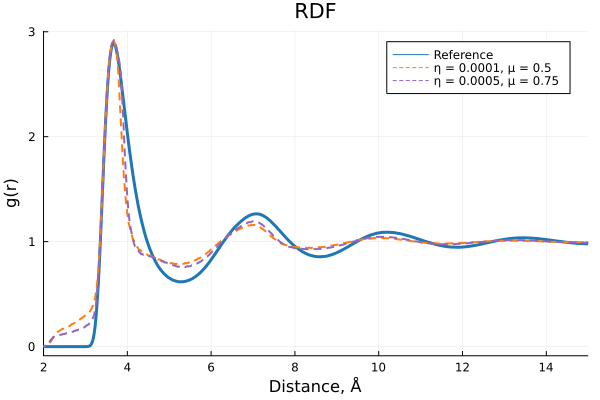

In [161]:
plot(bins, rdfref, xlim = (2, 15), linewidth=3, 
    labels="Reference", title="RDF", legend=:best, color=palette(:tab10)[1])
plot!(binsRDF, rdfNN1, xlim = (2, 15), linewidth=2, 
    linestyle=:dash, label="η = 0.0001, μ = 0.5", color=palette(:tab10)[2])
plot!(binsRDF, rdfNN3, xlim = (2, 15), linewidth=2, 
    linestyle=:dash, label="η = 0.0005, μ = 0.75", color=palette(:tab10)[5])
xlabel!("Distance, Å")
ylabel!("g(r)")

In [162]:
@load "model-iter-15.bson" model
model4 = copy(model.weight');

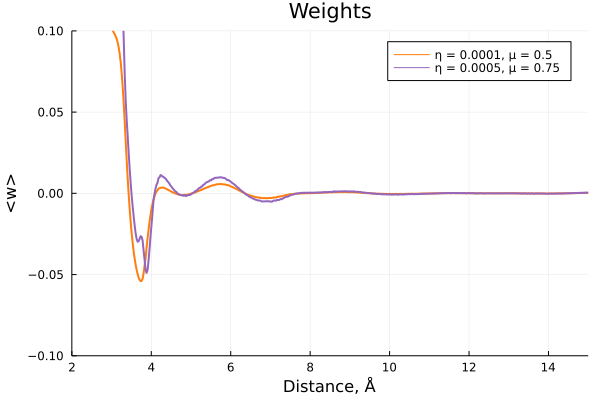

In [163]:
plot(bins, model1, title="Weights", 
    label="η = 0.0001, μ = 0.5", xlim=(2, 15), ylim=(-0.1, 0.1), lw=2, color=palette(:tab10)[2])
plot!(bins, model4, 
    label="η = 0.0005, μ = 0.75", xlim=(2, 15), ylim=(-0.1, 0.1), lw=2, color=palette(:tab10)[5])
xlabel!("Distance, Å")
ylabel!("<w>")